In [1]:
import cv2
import os
import math
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from shutil import copyfile
import time

In [2]:
# Device configuration
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
project_folder = os.path.expanduser("~/02456_Temp")
dataset_path = os.path.join(project_folder, "Dataset")
models_path = os.path.join(project_folder, "Models")
predictions_path = os.path.join(project_folder, "Preds")
zip_file_path = os.path.join(dataset_path, "project_20_data.zip")
project_20_data_path = os.path.join(dataset_path, "project_20_data")

In [4]:
dataset_path

'/home/steven/02456_Temp/Dataset'

In [5]:
# Unzip dataset
import zipfile
print('Unzipping:',zip_file_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

Unzipping: /home/steven/02456_Temp/Dataset/project_20_data.zip


In [6]:
generate_frames = True 
if generate_frames:
  videos = ["video1", "video2"]
  for video in videos:
      print(f"Processing {video}")
      video_original_frames_path = os.path.join(project_20_data_path, video, "video_frames")
      os.makedirs(video_original_frames_path, exist_ok=True)
      vidcap = cv2.VideoCapture(os.path.join(project_20_data_path, video+".avi"))
      success,image = vidcap.read()
      count = 0
      while success:
        cv2.imwrite(os.path.join(video_original_frames_path, "frame_%s.PNG" % str(count).zfill(6)), image)
        success,image = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1
        if (count % 500) == 0: 
          print(count)

Processing video1
500
1000
1500
2000
2500
3000
Processing video2


In [7]:
%%bash

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uf_6zoo8
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9


  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uf_6zoo8


In [8]:
frame = "frame_002008"
example_image = Image.open(os.path.join(project_20_data_path,"video1/video_frames/"+frame+".PNG"))

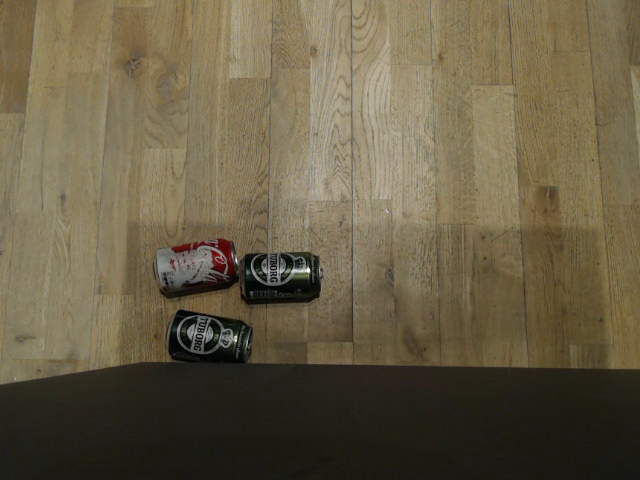

In [9]:
example_image

In [10]:
tree = ET.parse(os.path.join(project_20_data_path,"video1/frames/"+frame+".xml"))
root = tree.getroot()

example_image_drawing = ImageDraw.Draw(example_image)  

for obj in root.iter("object"):
  name = obj.find("name").text
  xmin = float(obj.find("bndbox").find("xmin").text)
  ymin = float(obj.find("bndbox").find("ymin").text)
  xmax = float(obj.find("bndbox").find("xmax").text)
  ymax = float(obj.find("bndbox").find("ymax").text)
  print(name,xmin,ymin,xmax,ymax)
  shape = [(xmin, ymin), (xmax, ymax)]
  
  if ("cola" in name) or ("coke" in name):
    color = "red"
  elif "beer" in name: 
    color = "green"
  else: 
    color = "blue"

  example_image_drawing.rectangle(shape, outline=color)

cola 145.4 235.12 238.09 297.04
beer 160.56 310.56 255.08 364.86
beer 239.7 247.56 327.63 308.94


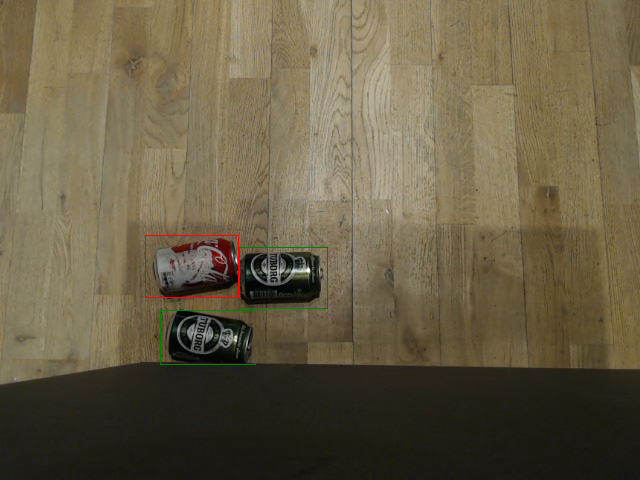

In [11]:
example_image

In [12]:
filtered_xml = True 
if filtered_xml:
  videos = ["video1", "video2"]
  for video in videos:
      print(f"Processing {video}")
      
      video_xml_filtered_path = os.path.join(project_20_data_path, video, "frames_filtered")
      video_xml_path = os.path.join(project_20_data_path, video, "frames")
      video_frames_path = os.path.join(project_20_data_path, video, "video_frames")
      video_frames_filtered_path = os.path.join(project_20_data_path, video, "video_frames_filtered")

      os.makedirs(video_xml_filtered_path, exist_ok=True)
      os.makedirs(video_frames_filtered_path, exist_ok=True)

      list_xml = list(sorted(os.listdir(video_xml_path)))
      number_original_xml = len(list_xml)

      for xml in list_xml:
        tree = ET.parse(os.path.join(video_xml_path, xml))
        root = tree.getroot()
        boxes = []
        for obj in root.iter("object"):
          name = obj.find("name").text
          xmin = float(obj.find("bndbox").find("xmin").text)
          ymin = float(obj.find("bndbox").find("ymin").text)
          xmax = float(obj.find("bndbox").find("xmax").text)
          ymax = float(obj.find("bndbox").find("ymax").text)
          boxes.append([xmin, ymin, xmax, ymax])
        #if boxes:
          src = os.path.join(video_xml_path, xml)
          dst = os.path.join(video_xml_filtered_path, xml)
          copyfile(src, dst)
          src_img = os.path.join(video_frames_path, root.find("filename").text)
          dst_img = os.path.join(video_frames_filtered_path, root.find("filename").text)
          copyfile(src_img,dst_img)
      number_filtered = len(os.listdir(video_xml_filtered_path))
      print(f"Number filtered {number_filtered}/{number_original_xml}")


Processing video1
Number filtered 1592/2177
Processing video2
Number filtered 179/252


In [13]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class BeerCansDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.xmls = list(sorted(os.listdir(os.path.join(root, "frames_filtered"))))
        self.imgs = list(sorted(os.listdir(os.path.join(root, "video_frames_filtered"))))

    def __getitem__(self, idx):
        scale_factor = 1
        #print(idx)
        #print(self.xmls[idx])
        tree = ET.parse(os.path.join(self.root, "frames_filtered", self.xmls[idx]))
        root = tree.getroot()
        # load images ad masks
        img_path = os.path.join(self.root, "video_frames_filtered", root.find("filename").text)
        img = Image.open(img_path).convert("RGB")
        width, height = img.size
        img = img.resize((int(width/scale_factor),int(height/scale_factor)))

        obj_ids = []
        boxes = []
        for obj in root.iter("object"):
          name = obj.find("name").text
          xmin = float(obj.find("bndbox").find("xmin").text)/scale_factor
          ymin = float(obj.find("bndbox").find("ymin").text)/scale_factor
          xmax = float(obj.find("bndbox").find("xmax").text)/scale_factor
          ymax = float(obj.find("bndbox").find("ymax").text)/scale_factor
          boxes.append([xmin, ymin, xmax, ymax])

          if ("cola" in name) or ("coke" in name):
            obj_ids.append(1)
          elif "beer" in name: 
            obj_ids.append(2)
          else: 
            # unknown label
            obj_ids.append(3)
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.as_tensor(obj_ids, dtype=torch.int64)
        image_id = torch.tensor([idx])
        if boxes.nelement() != 0: 
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
          area = torch.as_tensor([], dtype=torch.float32)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

(<PIL.Image.Image image mode=RGB size=640x480 at 0x7F178842A400>,
 {'boxes': tensor([[195.3400, 296.2500, 285.2100, 363.5600],
          [132.9700,  13.7600, 202.4800, 100.9900]]),
  'labels': tensor([2, 2]),
  'image_id': tensor([1114]),
  'area': tensor([6049.1489, 6063.3564]),
  'iscrowd': tensor([0, 0])})

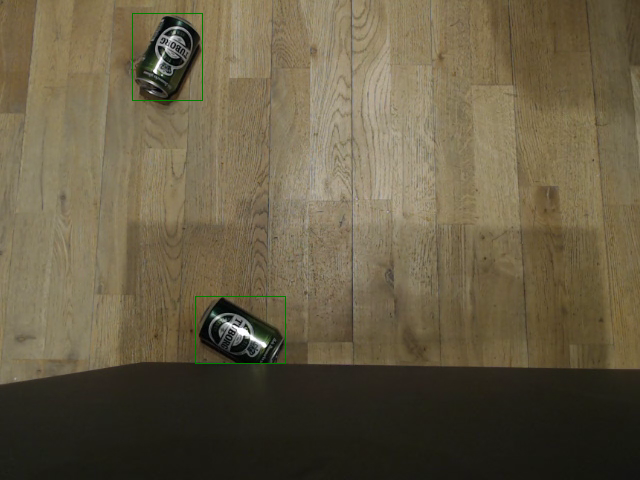

In [14]:
img_index = 1114
color_map = ["","red","green"]
root_dir = os.path.join(project_20_data_path, "video1")
root_dir2 = os.path.join(project_20_data_path, "video2")
dataset = BeerCansDataset(root_dir)
display(dataset[img_index])
dataset_image = dataset[img_index][0]
dataset_image_drawing = ImageDraw.Draw(dataset_image)  
index = 0
dataset_data = dataset[img_index][1]
for box in dataset_data["boxes"]:
  shape = [(box[0], box[1]), (box[2], box[3])]
  label = dataset_data["labels"][index].item()
  color = color_map[label]
  dataset_image_drawing.rectangle(shape, outline=color)
  index +=1 
display(dataset_image)

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [16]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [17]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = BeerCansDataset(root_dir, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/home/steven/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
# use our dataset and defined transformations
dataset = BeerCansDataset(root_dir, get_transform(train=True))
dataset_test = BeerCansDataset(root_dir, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# 318 is 20% of 1592 (total number of frames)
dataset = torch.utils.data.Subset(dataset, indices[:-318])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-318:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=6,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=6,
    collate_fn=utils.collate_fn)

In [20]:
dataset_video = BeerCansDataset(root_dir, get_transform(train=False))
dataset_video2 = BeerCansDataset(root_dir2, get_transform(train=False))

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [22]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

start_time = time.time()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
minutes = int((time.time() - start_time)/60)
print(f"Model trained in {minutes} minutes.")

Epoch: [0]  [  0/319]  eta: 0:10:57  lr: 0.000021  loss: 1.1173 (1.1173)  loss_classifier: 0.9536 (0.9536)  loss_box_reg: 0.1628 (0.1628)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.0608  data: 0.5704  max mem: 4001
Epoch: [0]  [ 10/319]  eta: 0:05:24  lr: 0.000178  loss: 1.0650 (0.9744)  loss_classifier: 0.8209 (0.7542)  loss_box_reg: 0.2048 (0.2156)  loss_objectness: 0.0016 (0.0032)  loss_rpn_box_reg: 0.0011 (0.0014)  time: 1.0497  data: 0.0587  max mem: 4268
Epoch: [0]  [ 20/319]  eta: 0:05:01  lr: 0.000335  loss: 0.5363 (0.7174)  loss_classifier: 0.2857 (0.4972)  loss_box_reg: 0.2048 (0.2151)  loss_objectness: 0.0016 (0.0036)  loss_rpn_box_reg: 0.0012 (0.0016)  time: 0.9566  data: 0.0069  max mem: 4268
Epoch: [0]  [ 30/319]  eta: 0:04:49  lr: 0.000492  loss: 0.4215 (0.6282)  loss_classifier: 0.2123 (0.3967)  loss_box_reg: 0.2509 (0.2256)  loss_objectness: 0.0022 (0.0043)  loss_rpn_box_reg: 0.0013 (0.0016)  time: 0.9768  data: 0.0078  max mem: 4268


In [23]:
print(len(dataset))
print(len(dataset_test))

1274
318


In [24]:
timestr = time.strftime("%Y%m%d-%H%M%S")
os.makedirs(models_path, exist_ok=True)
model_name = f"BeerCans_{num_epochs}-epochs_{minutes}-minutes_{timestr}.pth"
path = os.path.join(models_path, "StateDict_"+model_name)
torch.save(model.state_dict(), path)
print(path)
full_model_path = os.path.join(models_path, "FullModel_"+model_name)
torch.save(model, full_model_path)
print(full_model_path)

/home/steven/02456_Temp/Models/StateDict_BeerCans_1-epochs_6-minutes_20211129-162953.pth
/home/steven/02456_Temp/Models/FullModel_BeerCans_1-epochs_6-minutes_20211129-162953.pth


In [25]:
# pick one image from the test set
img, _ = dataset_test[64]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [26]:
prediction

[{'boxes': tensor([[133.2301,  13.1785, 203.6766, 105.3974],
          [538.9976, 221.5872, 608.7701, 270.8728]], device='cuda:0'),
  'labels': tensor([2, 2], device='cuda:0'),
  'scores': tensor([0.9929, 0.0555], device='cuda:0')}]

In [27]:
img

tensor([[[0.3686, 0.3686, 0.3686,  ..., 0.1137, 0.1137, 0.1137],
         [0.3765, 0.3255, 0.2863,  ..., 0.1098, 0.1098, 0.1059],
         [0.3804, 0.3098, 0.2941,  ..., 0.1098, 0.1098, 0.1059],
         ...,
         [0.1059, 0.1059, 0.1059,  ..., 0.0549, 0.0549, 0.0549],
         [0.1020, 0.1020, 0.1020,  ..., 0.0549, 0.0510, 0.0510],
         [0.0980, 0.0980, 0.0980,  ..., 0.0549, 0.0510, 0.0510]],

        [[0.3137, 0.3137, 0.3176,  ..., 0.1059, 0.1059, 0.1059],
         [0.3216, 0.2706, 0.2353,  ..., 0.1020, 0.1020, 0.0980],
         [0.3216, 0.2510, 0.2353,  ..., 0.1020, 0.1020, 0.0980],
         ...,
         [0.1098, 0.1098, 0.1098,  ..., 0.0549, 0.0549, 0.0549],
         [0.1059, 0.1059, 0.1059,  ..., 0.0549, 0.0510, 0.0510],
         [0.1020, 0.1020, 0.1020,  ..., 0.0549, 0.0510, 0.0510]],

        [[0.2471, 0.2471, 0.2314,  ..., 0.0627, 0.0627, 0.0627],
         [0.2549, 0.2039, 0.1490,  ..., 0.0588, 0.0588, 0.0549],
         [0.2471, 0.1765, 0.1529,  ..., 0.0588, 0.0588, 0.

In [28]:
# creating new Image object
predicted_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
# create rectangle image
img1 = ImageDraw.Draw(predicted_img)  


for pred in prediction:
    boxes = pred["boxes"]
    labels = pred["labels"]
    index = 0
    for box in boxes: 
        shape = [(box[0], box[1]), (box[2], box[3])]
        img1.rectangle(shape, outline =color_map[labels[index].item()])
        index += 1 

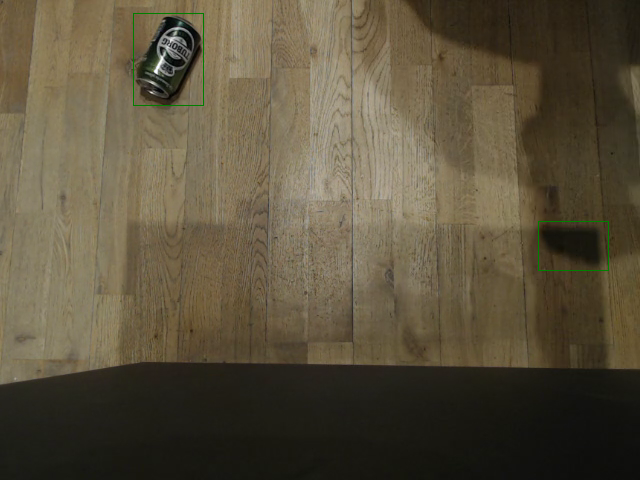

In [29]:
predicted_img

In [31]:
import numpy

In [ ]:
datasets_videos = [dataset_video, dataset_video2]
vid_number = 0
for dataset_vid in datasets_videos:
    frames_processed = 0
    width, height = predicted_img.size
    vid_number += 1
    preds_path = os.path.join(predictions_path,"predictions_"+str(vid_number)+"_"+model_name.split(".")[0])
    os.makedirs(preds_path, exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    video = cv2.VideoWriter(os.path.join(preds_path, "video"+str(vid_number)+"_"+model_name.split(".")[0]+".mp4"), fourcc, 24, (width,height))
    for i in range(len(dataset_vid)):
        img, _ = dataset_vid[i]
        # put the model in evaluation mode
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])
            frames_processed += 1
            # creating new Image object
            predicted_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
            # create rectangle image
            img1 = ImageDraw.Draw(predicted_img)  

            for pred in prediction:
                boxes = pred["boxes"]
                labels = pred["labels"]
                index = 0
                for box in boxes: 
                    shape = [(box[0], box[1]), (box[2], box[3])]
                    img1.rectangle(shape, outline =color_map[labels[index].item()])
                    index += 1 

            #predicted_img.save(f'{preds_path}/{str(i).zfill(6)}.jpg', 'JPEG')
            open_cv_image = numpy.array(predicted_img) 
            open_cv_image = open_cv_image[:, :, ::-1].copy() 
            video.write(open_cv_image)
            if (frames_processed % 250) == 0:
                print(frames_processed)
    cv2.destroyAllWindows()
    video.release()

250
500
750
1000
1250
1500
